<a href="https://colab.research.google.com/github/Teivak/BlaBlaBot/blob/main/2_HW_Filtering_Recognition_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Модели FaceRecognition довольно привередливы к обучающим данным:
1. Они плохо распознают одного человека в профиле и в анфасе (для них это разные люди), так что стоит их просто убрать.
2. Все лэндмарки должны быть в пределах ббоксов, иначе изображения не смогут нормально выровниться и не будут подходить для обучения.
3. Для каждой личности требуется как можно большее количество изображений, поэтому будем брать только те, которые соответствуют требованию.

# **1. Изображения в профиль**

Для начала избавимся от профильных изображений и оставим только фронтальные. Это можно сделать, используя лэндмарки (положение носа, относитально глаз и рта): в профиле нос выходит за точки рта и глаз или находится близко к границе.

In [ ]:
import pandas as pd

# Загружаем датафрейм с предсказанными лэндмарками
landmarks = pd.read_csv('PROJECT/FaceAlignment/pred_landmarks.csv', index_col='image_id')
landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,46.0,46.0,80.0,44.0,60.0,72.0,58.0,82.0,88.0,78.0
000002.jpg,46.0,46.0,80.0,46.0,58.0,68.0,48.0,82.0,82.0,82.0
000003.jpg,46.0,46.0,64.0,46.0,66.0,64.0,38.0,78.0,54.0,86.0
000004.jpg,46.0,46.0,76.0,46.0,66.0,70.0,40.0,82.0,64.0,82.0
000005.jpg,46.0,46.0,88.0,38.0,66.0,50.0,56.0,82.0,84.0,76.0


In [ ]:
# Вычисляем центр между глазами
landmarks['avg_eye_x'] = (landmarks['lefteye_x'] + landmarks['righteye_x']) / 2
landmarks['avg_eye_y'] = (landmarks['lefteye_y'] + landmarks['righteye_y']) / 2

# Вычисляем центр между уголками рта
landmarks['avg_mouth_x'] = (landmarks['leftmouth_x'] + landmarks['rightmouth_x']) / 2
landmarks['avg_mouth_y'] = (landmarks['leftmouth_y'] + landmarks['rightmouth_y']) / 2

# Вычисляем центр лица по осям X и Y, усредняя координаты глаз, носа и рта
landmarks['face_center_x'] = (landmarks['avg_eye_x'] + landmarks['nose_x'] + landmarks['avg_mouth_x']) / 3
landmarks['face_center_y'] = (landmarks['avg_eye_y'] + landmarks['nose_y'] + landmarks['avg_mouth_y']) / 3

# Вычисляем ширину лица как разницу между максимальной правой точкой (глаз или рот) и минимальной левой точкой (глаз или рот)
landmarks['face_width'] = landmarks[['righteye_x', 'rightmouth_x']].max(axis=1) - landmarks[['lefteye_x', 'leftmouth_x']].min(axis=1)
# Вычисляем высоту лица как разницу между средней точкой рта и средней точкой глаз по вертикали
landmarks['face_height'] = landmarks['avg_mouth_y'] - landmarks['avg_eye_y']

landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,avg_eye_x,avg_eye_y,avg_mouth_x,avg_mouth_y,face_center_x,face_center_y,face_width,face_height
image_id,,,,,,,,,,,,,,,,,,
000001.jpg,46.0,46.0,80.0,44.0,60.0,72.0,58.0,82.0,88.0,78.0,63.0,45.0,73.0,80.0,65.333333,65.666667,42.0,35.0
000002.jpg,46.0,46.0,80.0,46.0,58.0,68.0,48.0,82.0,82.0,82.0,63.0,46.0,65.0,82.0,62.000000,65.333333,36.0,36.0
000003.jpg,46.0,46.0,64.0,46.0,66.0,64.0,38.0,78.0,54.0,86.0,55.0,46.0,46.0,82.0,55.666667,64.000000,26.0,36.0
000004.jpg,46.0,46.0,76.0,46.0,66.0,70.0,40.0,82.0,64.0,82.0,61.0,46.0,52.0,82.0,59.666667,66.000000,36.0,36.0
000005.jpg,46.0,46.0,88.0,38.0,66.0,50.0,56.0,82.0,84.0,76.0,67.0,42.0,70.0,79.0,67.666667,57.000000,42.0,37.0


In [ ]:
import numpy as np

# 1. Вычисляем абсолютное горизонтальное смещение носа
landmarks['horizontal_nose_offset'] = np.abs(landmarks['nose_x'] - landmarks['face_center_x'])

# 2. Вычисляем nose_x_ratio, обрабатывая деление на ноль/отрицательную ширину лица
landmarks['nose_x_ratio'] = np.where(
    landmarks['face_width'] > 0,
    landmarks['horizontal_nose_offset'] / landmarks['face_width'],
    np.inf # Устанавливаем бесконечность, чтобы условие не выполнялось, если face_width равно нулю или отрицательно
)

# 3. Создаем булеву колонку is_horizontal_frontal
landmarks['is_horizontal_frontal'] = landmarks['nose_x_ratio'] < 0.15

# 4. Вычисляем вертикальное расстояние носа от среднего уровня глаз
landmarks['vertical_nose_position_relative_to_eyes'] = landmarks['nose_y'] - landmarks['avg_eye_y']

# 5. Вычисляем nose_y_ratio, обрабатывая деление на ноль/отрицательную высоту лица
landmarks['nose_y_ratio'] = np.where(
    landmarks['face_height'] > 0,
    landmarks['vertical_nose_position_relative_to_eyes'] / landmarks['face_height'],
    # Устанавливаем значение вне ожидаемого диапазона (например, -1), чтобы условие не выполнялось
    -1
)

# 6. Создаем булеву колонку is_vertical_frontal
landmarks['is_vertical_frontal'] = (
    # Значения допустимых диапазонов я подбирал
    (landmarks['nose_y_ratio'] >= 0.3) &
    (landmarks['nose_y_ratio'] <= 0.9)
)

landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,...,face_center_x,face_center_y,face_width,face_height,horizontal_nose_offset,nose_x_ratio,is_horizontal_frontal,vertical_nose_position_relative_to_eyes,nose_y_ratio,is_vertical_frontal
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,46.0,46.0,80.0,44.0,60.0,72.0,58.0,82.0,88.0,78.0,...,65.333333,65.666667,42.0,35.0,5.333333,0.126984,True,27.0,0.771429,True
000002.jpg,46.0,46.0,80.0,46.0,58.0,68.0,48.0,82.0,82.0,82.0,...,62.000000,65.333333,36.0,36.0,4.000000,0.111111,True,22.0,0.611111,True
000003.jpg,46.0,46.0,64.0,46.0,66.0,64.0,38.0,78.0,54.0,86.0,...,55.666667,64.000000,26.0,36.0,10.333333,0.397436,False,18.0,0.500000,True
000004.jpg,46.0,46.0,76.0,46.0,66.0,70.0,40.0,82.0,64.0,82.0,...,59.666667,66.000000,36.0,36.0,6.333333,0.175926,False,24.0,0.666667,True
000005.jpg,46.0,46.0,88.0,38.0,66.0,50.0,56.0,82.0,84.0,76.0,...,67.666667,57.000000,42.0,37.0,1.666667,0.039683,True,8.0,0.216216,False


In [ ]:
frontal_face_image_ids = landmarks[(landmarks['is_horizontal_frontal'] == True) & (landmarks['is_vertical_frontal'] == True)].index

print(f"Количество фронтальных изображений: {len(frontal_face_image_ids)}")
print("ID первых 5:")
print(frontal_face_image_ids[:5])

Количество фронтальных изображений: 169630
ID первых 5:
Index(['000001.jpg', '000002.jpg', '000006.jpg', '000007.jpg', '000008.jpg'], dtype='object', name='image_id')


In [ ]:
import kagglehub
import os
# Download latest version

source_path = kagglehub.dataset_download("kevinpatel04/celeba-original-wild-images")

print("Путь к датасету:", source_path)

Путь к датасету: /home/timof/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1


In [ ]:
# Функция, которая будет искать изображение в датасете по image_id
def path_from_image_id(image_id):
    part = (int(image_id[:-4]) - 1) // 10000 + 1
    path = os.path.join(source_path, f'Part {part}', f'Part {part}', image_id)
    return path

In [ ]:
bboxes = pd.read_csv(f'{source_path}/list_bbox_celeba.csv', index_col='image_id')
bboxes.head()

,x_1,y_1,width,height
image_id,,,,
000001.jpg,95,71,226,313
000002.jpg,72,94,221,306
000003.jpg,216,59,91,126
000004.jpg,622,257,564,781
000005.jpg,236,109,120,166


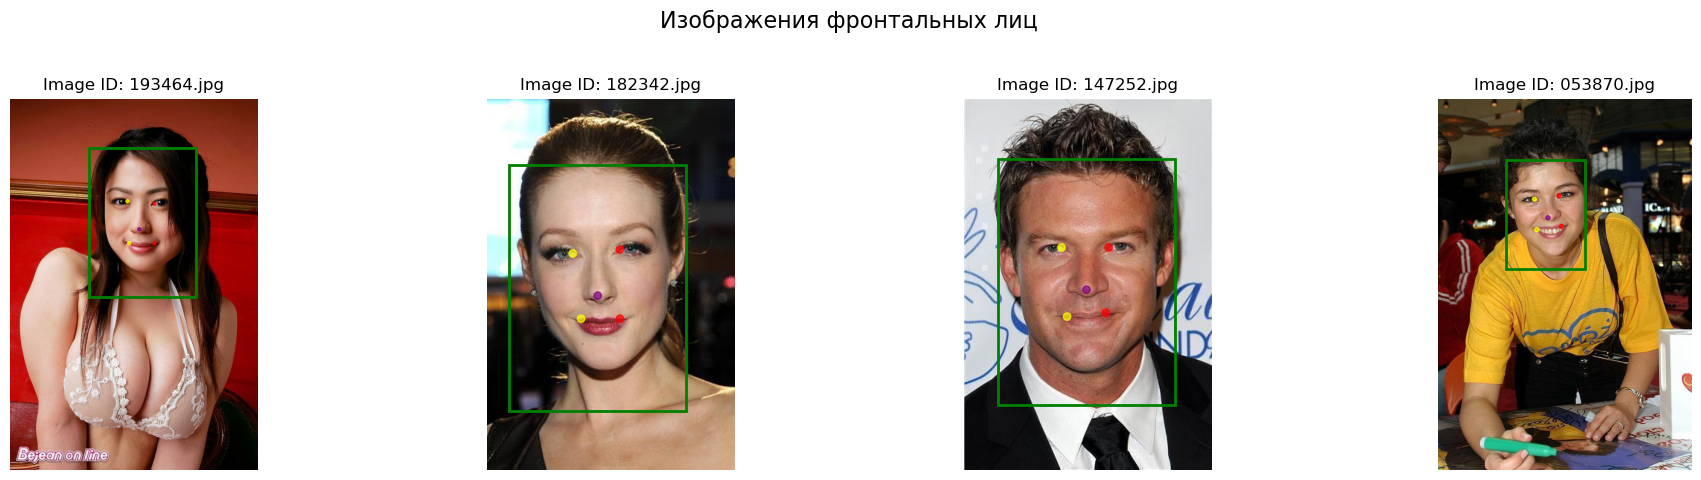

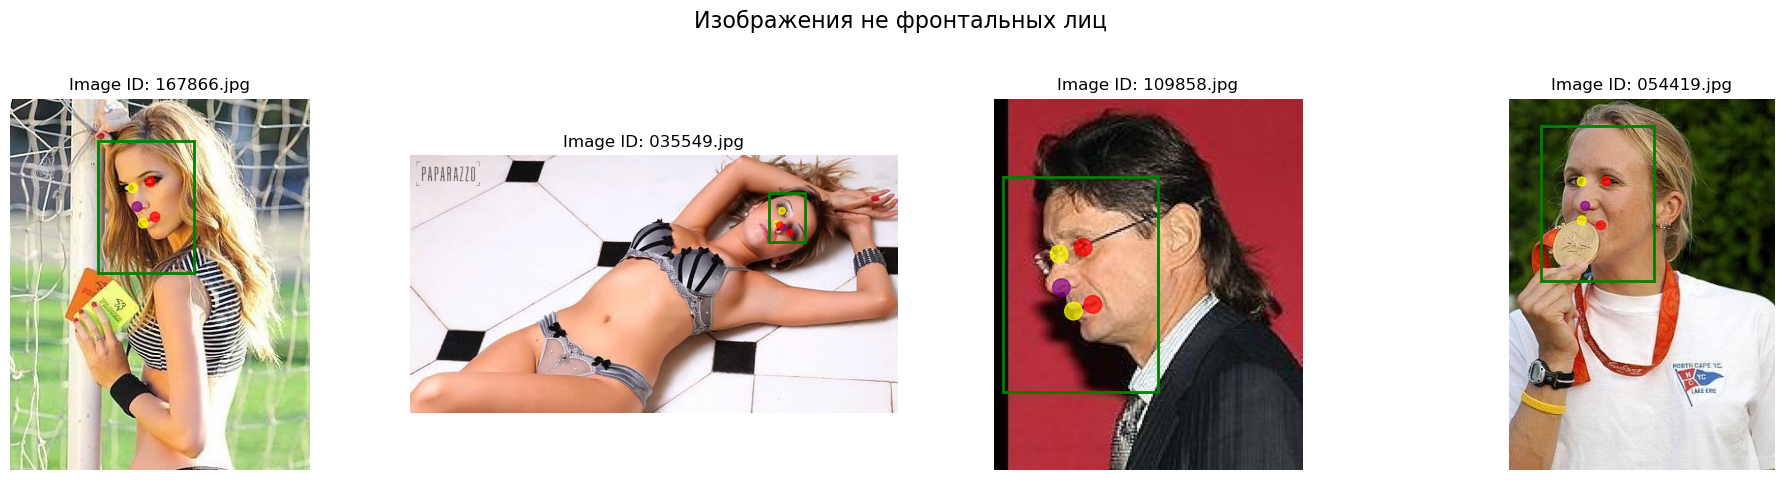

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

# Получаем image_id не фронтальных лиц
non_frontal_face_image_ids = landmarks[~(landmarks['is_horizontal_frontal'] & landmarks['is_vertical_frontal'])].index

# Выбираем 4 случайных image_ID фронтальных и 4 случайных image_ID не фронтальных лиц
random_frontal_ids = random.sample(list(frontal_face_image_ids), 4)
random_non_frontal_ids = random.sample(list(non_frontal_face_image_ids), 4)

def draw_landmarks_on_image(image_id, ax):
    # Формируем путь к изображению
    image_path = path_from_image_id(image_id)
    # Открываем изображение
    img = Image.open(image_path)
    # Отображаем изображение
    ax.imshow(img)
    # Устанавливаем заголовок
    ax.set_title(f"Image ID: {image_id}")
    # Выключаем оси
    ax.axis('off')

    # Получаем лэндмарки для текущего изображения
    current_landmarks = landmarks.loc[image_id]
    # Получаем координаты ограничивающей рамки
    bbox = bboxes.loc[image_id]
    x_1, y_1, width, height = bbox['x_1'], bbox['y_1'], bbox['width'], bbox['height']

    # Вычисляем коэффициенты масштабирования (лэндмарки предсказанны для изображений 128*128)
    scale_x = width / 128.0
    scale_y = height / 128.0

    # Определяем координаты и цвета лэндмарков (левые - жёлтый, правые - красный, нос - фиолетовый)
    landmark_data = [
        {'x': current_landmarks['lefteye_x'], 'y': current_landmarks['lefteye_y'], 'color': 'yellow'},
        {'x': current_landmarks['righteye_x'], 'y': current_landmarks['righteye_y'], 'color': 'red'},
        {'x': current_landmarks['nose_x'], 'y': current_landmarks['nose_y'], 'color': 'purple'},
        {'x': current_landmarks['leftmouth_x'], 'y': current_landmarks['leftmouth_y'], 'color': 'yellow'},
        {'x': current_landmarks['rightmouth_x'], 'y': current_landmarks['rightmouth_y'], 'color': 'red'}
    ]

    # Отображаем лэндмарки, скорректированные с учетом масштабирования и смещения ббокса
    for lm in landmark_data:
        transformed_x = lm['x'] * scale_x + x_1
        transformed_y = lm['y'] * scale_y + y_1
        ax.add_patch(patches.Circle((transformed_x, transformed_y), radius=5, color=lm['color'], alpha=0.7))

    # Рисуем ограничивающую рамку
    rect = patches.Rectangle((x_1, y_1), width, height, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

# Создаем фигуру с 1 строкой и 4 столбцами для фронтальных лиц
fig_frontal, axes_frontal = plt.subplots(1, 4, figsize=(20, 5))
fig_frontal.suptitle('Изображения фронтальных лиц', fontsize=16)
for i, image_id in enumerate(random_frontal_ids):
    draw_landmarks_on_image(image_id, axes_frontal[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Создаем фигуру с 1 строкой и 4 столбцами для не фронтальных лиц
fig_non_frontal, axes_non_frontal = plt.subplots(1, 4, figsize=(20, 5))
fig_non_frontal.suptitle('Изображения не фронтальных лиц', fontsize=16)
for i, image_id in enumerate(random_non_frontal_ids):
    draw_landmarks_on_image(image_id, axes_non_frontal[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Мы успешно исключили все не фронтальные лица.

Отфильтрованное в frontal_face_image_ids

# **2. Ббоксы**

In [ ]:
true_landmarks = pd.read_csv('PROJECT/FaceAlignment/landmarks.csv', index_col='image_id')
true_landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,165,184,244,176,196,249,194,271,266,260
000002.jpg,140,204,220,204,168,254,146,289,226,289
000003.jpg,244,104,264,105,263,121,235,134,251,140
000004.jpg,796,539,984,539,930,687,762,756,915,756
000005.jpg,273,169,328,161,298,172,283,208,323,207


В функции is_within_bbox нельзя использовать предсказанные лэндмарки, потому что они были предсказанны для уже обрезанного изображения, и все находятся внутри ббокса. После масштабирования они также останутся внутри, поэтому функция не сработает.

Поэтому используем исходные лэндмарки, а потом выведем отсеянные изображения с предсказанными, чтобы посмотреть, правильно ли мы сделали.

In [ ]:
def is_within_bbox(image_id):
    # Получаем координаты ббокса
    bbox = bboxes.loc[image_id]
    x_1, y_1, width, height = bbox['x_1'], bbox['y_1'], bbox['width'], bbox['height']
    bbox_x_max = x_1 + width
    bbox_y_max = y_1 + height

    # Получаем координаты лэндмарков
    lms = true_landmarks.loc[image_id]
    landmark_coords = [
        (lms['lefteye_x'], lms['lefteye_y']),
        (lms['righteye_x'], lms['righteye_y']),
        (lms['nose_x'], lms['nose_y']),
        (lms['leftmouth_x'], lms['leftmouth_y']),
        (lms['rightmouth_x'], lms['rightmouth_y'])
    ]

    # Проверяем, находятся ли все ключевые точки внутри ббокса
    for lx, ly in landmark_coords:
        if not (x_1 <= lx <= bbox_x_max and y_1 <= ly <= bbox_y_max):
            return False
    return True

# Применяем функцию к image_ids фронтальных лиц
frontal_face_image_ids_bbox_compliant = [image_id for image_id in frontal_face_image_ids if is_within_bbox(image_id)]

print(f"Количество изображений фронтальных лиц после фильтрации по ббоксам: {len(frontal_face_image_ids_bbox_compliant)}")
print("Первые 5 ID изображений фронтальных лиц после фильтрации по ббоксам:")
print(frontal_face_image_ids_bbox_compliant[:5])

Количество изображений фронтальных лиц после фильтрации по ббоксам: 169328
Первые 5 ID изображений фронтальных лиц после фильтрации по ббоксам:
['000001.jpg', '000002.jpg', '000006.jpg', '000007.jpg', '000008.jpg']


In [ ]:
discarded_image_ids = set(frontal_face_image_ids) - set(frontal_face_image_ids_bbox_compliant)

print(f"Количество отсеянных изображений: {len(discarded_image_ids)}")
print(f"ID первых 5: {list(discarded_image_ids)[:5]}")


Количество отсеянных изображений: 302
ID первых 5: ['117633.jpg', '121708.jpg', '103645.jpg', '200076.jpg', '089317.jpg']


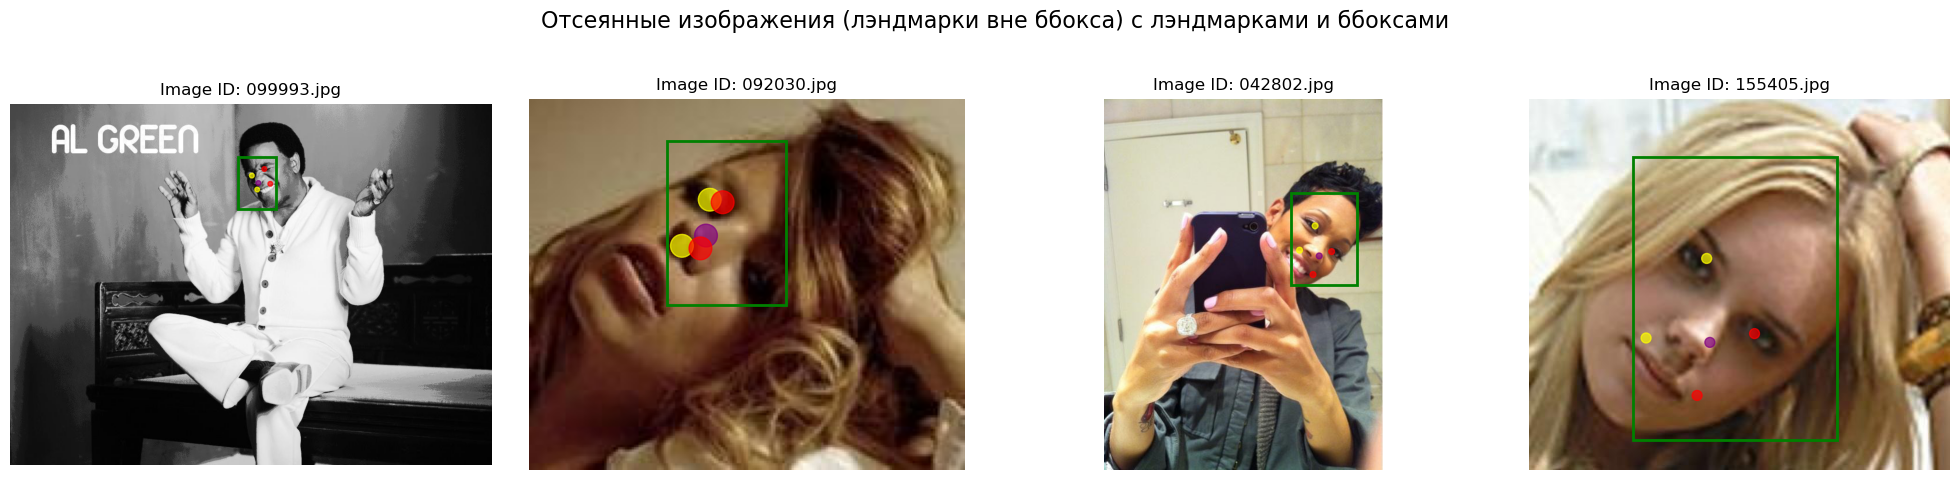

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

# Выбираем 4 случайных ID отсеянных изображений
# Убедимся, что отсеянных изображений достаточно для выборки
if len(discarded_image_ids) >= 4:
    random_discarded_ids = random.sample(list(discarded_image_ids), 4)
else:
    random_discarded_ids = list(discarded_image_ids)
    print(f"Внимание: Только {len(discarded_image_ids)} изображений были отсеяны, отображаем их все.")

# Функция draw_landmarks_on_image уже определена и рисует по предсказанным лэндмаркам

# Создаем фигуру с 1 строкой и 4 столбцами для отсеянных изображений
fig_discarded, axes_discarded = plt.subplots(1, len(random_discarded_ids), figsize=(20, 5))
fig_discarded.suptitle('Отсеянные изображения (лэндмарки вне ббокса) с лэндмарками и ббоксами', fontsize=16)

# Обрабатываем случай, когда отображается только одно изображение (axes_discarded не будет массивом)
if len(random_discarded_ids) == 1:
    draw_landmarks_on_image(random_discarded_ids[0], axes_discarded)
else:
    for i, image_id in enumerate(random_discarded_ids):
        draw_landmarks_on_image(image_id, axes_discarded[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Корректируем макет, чтобы освободить место для заголовка
plt.show()

Как видим, лэндмарки на изображениях предсказались криво, потому что ключевая точка находится вне ббокса, а модель не может туда её поставить. Такой случай нам тоже не подходит, потому что кривые лэндмарки криво выровнятся.

Отфильтрованное в frontal_face_image_ids_bbox_compliant

# **3. Личности**

In [ ]:
# Загружаем датафрейм с личностями
identity = pd.read_csv('PROJECT/FaceAlignment/identity.csv', index_col='image_id')
identity.head()

,person_id
image_id,
000001.jpg,2880
000002.jpg,2937
000003.jpg,8692
000004.jpg,5805
000005.jpg,9295


In [ ]:
identity = identity[identity.index.isin(frontal_face_image_ids_bbox_compliant)]
print(f"Количество изображений после фильтрации: {len(identity)}")
identity.head()

Количество изображений после фильтрации: 169328


,person_id
image_id,
000001.jpg,2880
000002.jpg,2937
000006.jpg,4153
000007.jpg,9040
000008.jpg,6369


Личности с малым количеством изображений нам вообще не подходят, так как на них ни обучить, ни проверить работу модели не получится.

Сделаем минимальным количеством встреч - 5, такие можно использовать на валидационной выборке для FaceRecognition.

In [ ]:
person_id_counts = identity['person_id'].value_counts()
person_id_counts = person_id_counts[person_id_counts >= 5]
print(person_id_counts)

person_id
4691    30
5426    30
4978    30
56      30
6282    30
        ..
2687     5
6538     5
7462     5
6601     5
5792     5
Name: count, Length: 9078, dtype: int64


Максимальное количество изображений для одной личности - 30. Отберём изображения для обучающей и валидационной выборок.

In [ ]:
import random

# Фильтруем person_id_counts, чтобы получить личности с 25+ изображениями
person_id_counts_25plus = person_id_counts[person_id_counts >= 25]

# Получаем список person_id, которые соответствуют критерию 25+ изображений
selected_person_ids = person_id_counts_25plus.index.tolist()

val_dataset = []
train_dataset = []

# Перебираем каждый выбранный person_id
for person_id in selected_person_ids:
    # Получаем все image_id для текущего person_id
    images_for_person = identity[identity['person_id'] == person_id].index.tolist()

    # Случайным образом выбираем 5 изображений для валидационного набора данных
    val_images = random.sample(images_for_person, 5)
    val_dataset.extend(val_images)

    # Оставшиеся изображения идут в тренировочный набор данных
    train_images = [img for img in images_for_person if img not in val_images]
    train_dataset.extend(train_images)

print(f"Количество person_id с 25+ изображениями: {len(selected_person_ids)}")
print(f"Всего изображений в val_dataset: {len(val_dataset)}")
print(f"Всего изображений в train_dataset: {len(train_dataset)}")

# Получаем person_id для каждого изображения в val_dataset
val_dataset = identity[identity.index.isin(val_dataset)]
print("\nЛичность для валидационного набора данных (первые 5):")
display(val_dataset.head())

# Получаем person_id для каждого изображения в train_dataset
train_dataset = identity[identity.index.isin(train_dataset)]
print("\nЛичность для тренировочного набора данных (первые 5):")
train_dataset.head()

Количество person_id с 25+ изображениями: 1944
Всего изображений в val_dataset: 9720
Всего изображений в train_dataset: 42594

Личность для валидационного набора данных (первые 5):


,person_id
image_id,
000001.jpg,2880
000009.jpg,3332
000019.jpg,2929
000022.jpg,6642
000023.jpg,1



Личность для тренировочного набора данных (первые 5):


,person_id
image_id,
000002.jpg,2937
000007.jpg,9040
000008.jpg,6369
000010.jpg,612
000014.jpg,7081


In [ ]:
import random

# Определяем person_id, у которых 5+ изображений
# Но которые НЕ были выбраны для наборов train/val (для которых требовалось 25+ изображений)
already_selected_person_ids_for_train_val = set(selected_person_ids)
candidate_test_person_ids = [
    pid for pid in person_id_counts.index
    if pid not in already_selected_person_ids_for_train_val
]

print(f"Количество потенциальных person_id для test_dataset (5+ изображений, не в train/val): {len(candidate_test_person_ids)}")

# Выбираем 1000 случайных person_id из кандидатов для test_dataset
# Убеждаемся, что достаточно кандидатов для выборки 1000
num_persons_for_test = min(1000, len(candidate_test_person_ids))
selected_test_person_ids = random.sample(candidate_test_person_ids, num_persons_for_test)

test_dataset = []

# Для каждого выбранного person_id для теста получаем 5 случайных изображений
for person_id in selected_test_person_ids:
    images_for_person = identity[identity['person_id'] == person_id].index.tolist()
    # Убеждаемся, что у человека действительно 5 или более изображений (согласно начальному фильтру person_id_counts)
    if len(images_for_person) >= 5:
        test_images = random.sample(images_for_person, 5)
        test_dataset.extend(test_images)

print(f"Количество выбранных person_id для test_dataset: {len(selected_test_person_ids)}")
print(f"Всего изображений в test_dataset: {len(test_dataset)}")
test_dataset = identity[identity.index.isin(test_dataset)]
test_dataset.head()

Количество потенциальных person_id для test_dataset (5+ изображений, не в train/val): 7134
Количество выбранных person_id для test_dataset: 1000
Всего изображений в test_dataset: 5000


,person_id
image_id,
000080.jpg,3286
000095.jpg,2410
000207.jpg,7410
000244.jpg,9455
000268.jpg,3144


Всё готово. Сохраняем выборки для использования в следующих ноутбуках.

In [ ]:
train_dataset.to_csv('PROJECT/FaceAlignment/train_dataset.csv', index=True)
val_dataset.to_csv('PROJECT/FaceAlignment/val_dataset.csv', index=True)
test_dataset.to_csv('PROJECT/FaceAlignment/test_dataset.csv', index=True)